# Gaussian Mixture Model

Requirements: 
- python 3
- matplotlib
- numpy
- scikit learn

## Generate Test Data

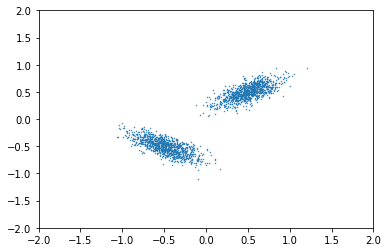

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

mean_1      = np.array([0.5,0.5])
cov_1       = 0.02*np.array([[2,1],[1,1]])
sample_num1 = np.array([1000])
data1       = np.random.multivariate_normal(mean_1,cov_1,sample_num1)

mean_2      = np.array([-0.5,-0.5])
cov_2       = 0.02*np.array([[2,-1],[-1,1]])
sample_num2 = np.array([1000])
data2       = np.random.multivariate_normal(mean_2,cov_2,sample_num2)

# Join and randomly shuffle data
data = np.vstack((data1,data2))
np.random.shuffle(data)

plt.figure(1);
plt.scatter(np.transpose(data)[0],np.transpose(data)[1], 0.2);
plt.xlim(-2,+2);
plt.ylim(-2,+2);

Mean 0
[0.49894037 0.50113831] 

Covariance 0
[[0.03716104 0.01916169]
 [0.01916169 0.02017502]] 

Mean 1
[-0.48668727 -0.50511484] 

Covariance 1
[[ 0.04349078 -0.02129421]
 [-0.02129421  0.02070766]] 



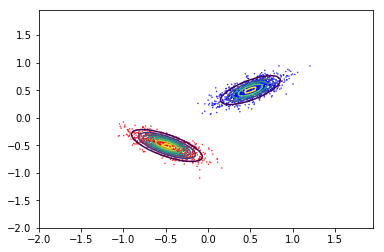

In [2]:
import numpy as np
from sklearn import mixture

np.random.seed(1)
n_components = 2
GMM  = mixture.GaussianMixture(n_components)
GMM.fit(data)
labels = GMM.predict(data)

for i in range(n_components):
    print('Mean',i)
    print(GMM.means_[i], '\n')
    print('Covariance',i)
    print(GMM.covariances_[i],'\n')

# Plot Cluster Fits
dx = .05
X,Y = np.meshgrid(np.arange(-2, +2, dx), np.arange(-2, +2, dx))

# Define exponential distribution
def p(x, y, ind):
    vec = np.array([x,y])
    return 1.0/((2*np.pi)**2 * np.linalg.det(GMM.covariances_[ind]))**0.5 * np.exp(-0.5*np.transpose(vec-GMM.means_[ind])@np.linalg.inv(GMM.covariances_[ind])@(vec-GMM.means_[ind]))

Z1 = np.vectorize(p)(*[X,Y], 0)
Z2 = np.vectorize(p)(*[X,Y], 1)

plt.figure(2)
plt.contour(X,Y,Z1);
plt.contour(X,Y,Z2);
plt.scatter(np.transpose(data)[0],np.transpose(data)[1], s=0.2, c=labels, cmap='bwr');

# Gaussian Processes

## Generate Test Data for GPs

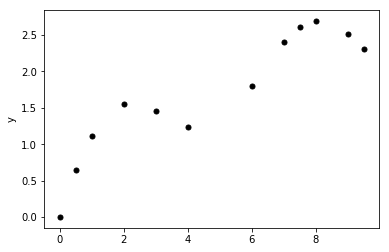

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

mu    = 0 
sigma = 0.05

xvals = np.arange(20)/2
xvals = np.delete(xvals,[3,5,7,9,10,11,13,17])
def f(x):
    return np.log(1+x) + 0.5*np.sin(x)

data  = f(xvals)
plt.figure(1)
plt.scatter(xvals,data,marker=".",s=100,c="black");
plt.xlabel('');
plt.ylabel('y');

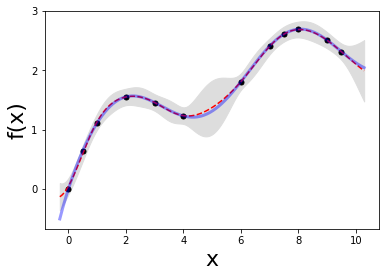

In [4]:
# Train data
x_train = xvals
y_train = (data-np.mean(data))

# Test data
sample_num     = 500 # number of sampling points
max_sample_val = 10.3
Xtest = np.arange(-0.3, max_sample_val+1e-6, max_sample_val/(sample_num-1))
x_all = np.hstack((x_train,Xtest))

def Ker(vec1, vec2, length_scale):
    v1,v2 = np.meshgrid(vec1,vec2,indexing='ij')
    return np.exp(-(v1-v2)**2/(2*length_scale**2))

class GaussianProcess:
    def __init__(self, Ker, length_scale, σ_noise, x_all, y_train):
        
        self.K = Ker(x_all,x_all,length_scale)
        self.K11 = self.K[0:x_train.shape[0],0:x_train.shape[0]]
        self.K21 = self.K[x_train.shape[0]:,0:x_train.shape[0]]
        self.K12 = np.transpose(self.K21)
        self.K22 = self.K[x_train.shape[0]:,x_train.shape[0]:]

        self.σ_noise = σ_noise

        self.K11_inv = np.linalg.inv(self.K11 + (self.σ_noise**2)*np.eye(self.K11.shape[0]))
        self.μ_inferred = self.K21@self.K11_inv@y_train
        self.Σ_inferred = (self.K22 + (self.σ_noise**2)*np.eye(self.K22.shape[0])) - self.K21@self.K11_inv@self.K12
        self.std_dev    = np.sqrt(np.abs(np.diag(self.Σ_inferred)))

def main():
    length_scale = 1.; σ_noise = 1e-1;
    GP = GaussianProcess(Ker,length_scale, σ_noise, x_all, y_train)
    
    plt.figure(4);
    plt.plot(Xtest,np.mean(data) + GP.μ_inferred,'r--', lw=1.5);
    std_dev_num = 1
    plt.gca().fill_between(Xtest, np.mean(data) + GP.μ_inferred-std_dev_num*GP.std_dev, np.mean(data) + GP.μ_inferred+std_dev_num*GP.std_dev, color="#dddddd")
    plt.scatter(xvals,np.mean(data) + y_train,marker=".",s=100,c="black");
    plt.xlabel('x', fontsize=22)
    plt.ylabel('f(x)', fontsize=22)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14) 
    plt.plot(Xtest,f(Xtest),color="blue",linewidth=3, alpha=0.4)
    
if __name__ == '__main__':
    main() 